In [26]:
# for execution on colab

from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# from densenet.py
from densenet import DenseNet
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


In [28]:
# Define possible characters in the captchas from 0-9 and a-z
CHARSET = "0123456789abcdefghijklmnopqrstuvwxyz"
# Map each character to an index
CHAR2IDX = {c: i for i, c in enumerate(CHARSET)}

def encode_label(text, num_chars=5):
    return torch.LongTensor([CHAR2IDX[c] for c in text.lower()[:num_chars]])

class CaptchaDataset(Dataset):
    def __init__(self, image_dir, max_len=5):
        self.paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
        self.max_len = max_len

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224)) / 255.0
        img = torch.tensor(img).unsqueeze(0).float()
        label_str = os.path.basename(path).split(".")[0]
        label = encode_label(label_str, self.max_len)
        return img, label

In [29]:
def get_accuracies(model, dataloader, device='cuda'):
    """
    Calculate 2 accuracies for captchas:
    - character accuracy: number of correct characters / total characters
    - captcha accuracy: number of correct captchas / total captchas
    where the captcha accuracy is defined as the number of correct predictions for all 5 characters
    """
    total_chars = 0
    correct_chars = 0
    total_captcha = 0
    correct_captcha = 0
    model.eval()

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            preds = model(images)
            predicted_chars = torch.stack([torch.argmax(pred, dim=1) for pred in preds], dim=1)

            # add to the total counts
            total_chars += labels.numel()
            # sum the number of correct characters
            correct_chars += (predicted_chars == labels).sum().item()

            total_captcha += labels.size(0)
            # check if all characters are correct for the captcha
            correct_captcha += (predicted_chars == labels).all(dim=1).sum().item()

    char_acc = correct_chars / total_chars
    captcha_acc = correct_captcha / total_captcha
    return char_acc, captcha_acc

# training loop and logs based on the code from TP3
def print_logs(dataset_type: str, logs: dict):
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)

def loss_batch(model, x, y, config):
    """
    Compute loss associated with this batch.
    """
    device = config['device']
    loss_fn = config['loss']
    metrics = dict()

    x, y = x.to(device), y.to(device)

    preds = model(x)
    targets = y

    logits = torch.stack(preds, dim=1)
    logits = logits.view(-1, logits.shape[-1])
    targets = targets.view(-1)

    loss = loss_fn(logits, targets)
    # metrics['loss'] = loss.item()
    metrics['loss'] = loss
    return metrics

def eval_model(model, dataloader, config):
    """
    Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(dataloader):
            metrics = loss_batch(model, x, y, config)
            for name, value in metrics.items():
                logs[name].append(value)

    for name in logs:
        logs[name] = sum(logs[name]) / len(logs[name])

    char_acc, captcha_acc = get_accuracies(model, dataloader, device)
    logs['char_acc'] = char_acc
    logs['captcha_acc'] = captcha_acc
    return logs

def train_model(model, train_loader, val_loader, config):
    train_loader = config['train_loader']
    val_loader = config['val_loader']
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']
    epochs = config['epochs']
    log_every = config['log_every']

    print(f'Starting training for {config["epochs"]} epochs, using {device}.')

    # for visualization
    train_losses = []
    eval_losses = []
    char_accuracies = []
    captcha_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            metrics = loss_batch(model, x, y, config)
            loss = metrics['loss']

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            loss.backward()
            optimizer.step()

            logs['loss'].append(loss.item())

            if batch_id % log_every == 0 and batch_id > 0:
                avg_logs = {name: np.mean(vals) for name, vals in logs.items()}
                print_logs("Train", avg_logs)
                logs = defaultdict(list)

        if len(logs) > 0:
            avg_logs = {name: np.mean(vals) for name, vals in logs.items()}
            print_logs("Train", avg_logs)

        val_logs = eval_model(model, val_loader, config)
        print_logs("Eval", val_logs)

        train_losses.append(avg_logs['loss'])
        eval_losses.append(val_logs['loss'])
        char_accuracies.append(val_logs['char_acc'])
        captcha_accuracies.append(val_logs['captcha_acc'])

        # preview predictions from validation set
        sample_images, sample_labels = next(iter(val_loader))
        sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
        sample_preds = model(sample_images)
        sample_pred_chars = torch.stack([torch.argmax(p, dim=1) for p in sample_preds], dim=1)
        for i in range(min(5, sample_images.size(0))):
            pred_str = ''.join(CHARSET[c.item()] for c in sample_pred_chars[i])
            true_str = ''.join(CHARSET[c.item()] for c in sample_labels[i])
            print(f"[{i}] True: {true_str} | Pred: {pred_str}")

    return train_losses, eval_losses, char_accuracies, captcha_accuracies



### For training, the paper usese 100 epochs with a batch size of 16 and learning rate of 0.001, with SGD as the optimizer.

In [30]:
print("📂 Current working directory:")
print(os.getcwd())
print("\n📂 Contents:")
print(os.listdir('.'))

📂 Current working directory:
/content

📂 Contents:
['.config', 'drive', 'sample_data']


In [31]:
# captcha_dir = "captcha_data/samples"
captcha_dir = "drive/MyDrive/captcha_data/samples"
batch_size = 16
num_workers = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = CaptchaDataset(captcha_dir)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = DenseNet(
    growth_rate=32,
    block_config=(6, 6, 24, 16),
    num_init_features=64,
    bn_size=4,
    drop_rate=0.2,
    num_classes=36,
    num_characters=5
)

config = {
    'train_loader': train_loader,
    'val_loader': val_loader,
    'optimizer': torch.optim.Adam(model.parameters(), lr=0.001),
    'loss': nn.CrossEntropyLoss(),
    'clip': 1.0,
    'device': device,
    'epochs': 100,
    'log_every': 20,
}

train_losses, eval_losses, char_accuracies, captcha_accuracies = train_model(model, train_loader, val_loader, config)

Starting training for 100 epochs, using cuda.

Epoch 1
Train -   loss: 3.16
Train -   loss: 2.91
Train -   loss: 2.90


100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Eval -    loss: 3.33     char_acc: 0.06 captcha_acc: 0.00
[0] True: d75b5 | Pred: y5352
[1] True: x7547 | Pred: y5352
[2] True: 36bc2 | Pred: y5352
[3] True: 8cccc | Pred: y5352
[4] True: 36nx4 | Pred: y5352

Epoch 2
Train -   loss: 2.83
Train -   loss: 2.76
Train -   loss: 2.73


100%|██████████| 13/13 [00:01<00:00,  8.23it/s]


Eval -    loss: 3.53     char_acc: 0.08 captcha_acc: 0.00
[0] True: d75b5 | Pred: 27f5x
[1] True: x7547 | Pred: 27f5x
[2] True: 36bc2 | Pred: 27fnx
[3] True: 8cccc | Pred: x7cnn
[4] True: 36nx4 | Pred: 27f5x

Epoch 3
Train -   loss: 2.63
Train -   loss: 2.62
Train -   loss: 2.62


100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


Eval -    loss: 3.07     char_acc: 0.14 captcha_acc: 0.00
[0] True: d75b5 | Pred: 47f2f
[1] True: x7547 | Pred: xfc7f
[2] True: 36bc2 | Pred: 44nce
[3] True: 8cccc | Pred: 4cccx
[4] True: 36nx4 | Pred: xxn7f

Epoch 4
Train -   loss: 2.48
Train -   loss: 2.46
Train -   loss: 2.40


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Eval -    loss: 2.84     char_acc: 0.14 captcha_acc: 0.00
[0] True: d75b5 | Pred: x7ff5
[1] True: x7547 | Pred: x7fx5
[2] True: 36bc2 | Pred: c8n83
[3] True: 8cccc | Pred: cxccy
[4] True: 36nx4 | Pred: 7fmn7

Epoch 5
Train -   loss: 2.30
Train -   loss: 2.28
Train -   loss: 2.30


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 2.47     char_acc: 0.22 captcha_acc: 0.00
[0] True: d75b5 | Pred: f73b2
[1] True: x7547 | Pred: f7ff3
[2] True: 36bc2 | Pred: 55g82
[3] True: 8cccc | Pred: cccce
[4] True: 36nx4 | Pred: x7nn4

Epoch 6
Train -   loss: 2.17
Train -   loss: 2.13
Train -   loss: 2.11


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Eval -    loss: 2.78     char_acc: 0.18 captcha_acc: 0.00
[0] True: d75b5 | Pred: 2n72f
[1] True: x7547 | Pred: xx77f
[2] True: 36bc2 | Pred: 3nncx
[3] True: 8cccc | Pred: cnccx
[4] True: 36nx4 | Pred: 3nnxf

Epoch 7
Train -   loss: 1.99
Train -   loss: 1.97
Train -   loss: 1.96


100%|██████████| 13/13 [00:01<00:00,  8.51it/s]


Eval -    loss: 2.62     char_acc: 0.20 captcha_acc: 0.00
[0] True: d75b5 | Pred: y7582
[1] True: x7547 | Pred: x7fff
[2] True: 36bc2 | Pred: c38e2
[3] True: 8cccc | Pred: c3ccc
[4] True: 36nx4 | Pred: 34nn4

Epoch 8
Train -   loss: 1.79
Train -   loss: 1.83
Train -   loss: 1.80


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Eval -    loss: 2.88     char_acc: 0.18 captcha_acc: 0.00
[0] True: d75b5 | Pred: 27352
[1] True: x7547 | Pred: xc355
[2] True: 36bc2 | Pred: 22852
[3] True: 8cccc | Pred: c232c
[4] True: 36nx4 | Pred: 24ww8

Epoch 9
Train -   loss: 1.71
Train -   loss: 1.65
Train -   loss: 1.63


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Eval -    loss: 3.21     char_acc: 0.15 captcha_acc: 0.00
[0] True: d75b5 | Pred: 67383
[1] True: x7547 | Pred: x7785
[2] True: 36bc2 | Pred: 248g2
[3] True: 8cccc | Pred: 63e2e
[4] True: 36nx4 | Pred: 53ww4

Epoch 10
Train -   loss: 1.52
Train -   loss: 1.56
Train -   loss: 1.49


100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Eval -    loss: 2.04     char_acc: 0.30 captcha_acc: 0.00
[0] True: d75b5 | Pred: 47583
[1] True: x7547 | Pred: x75f7
[2] True: 36bc2 | Pred: 34b22
[3] True: 8cccc | Pred: 63ccx
[4] True: 36nx4 | Pred: 3ebx4

Epoch 11
Train -   loss: 1.37
Train -   loss: 1.36
Train -   loss: 1.33


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Eval -    loss: 1.77     char_acc: 0.43 captcha_acc: 0.00
[0] True: d75b5 | Pred: b75b2
[1] True: x7547 | Pred: x73b7
[2] True: 36bc2 | Pred: 8bbc2
[3] True: 8cccc | Pred: 6cc2c
[4] True: 36nx4 | Pred: 3bnx4

Epoch 12
Train -   loss: 1.23
Train -   loss: 1.22
Train -   loss: 1.19


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Eval -    loss: 2.14     char_acc: 0.32 captcha_acc: 0.01
[0] True: d75b5 | Pred: 47788
[1] True: x7547 | Pred: x75b5
[2] True: 36bc2 | Pred: 34b68
[3] True: 8cccc | Pred: 88cee
[4] True: 36nx4 | Pred: 76mn4

Epoch 13
Train -   loss: 1.08
Train -   loss: 1.11
Train -   loss: 1.09


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


Eval -    loss: 1.58     char_acc: 0.47 captcha_acc: 0.01
[0] True: d75b5 | Pred: b7783
[1] True: x7547 | Pred: x7385
[2] True: 36bc2 | Pred: 24b22
[3] True: 8cccc | Pred: 88ccc
[4] True: 36nx4 | Pred: 38nx4

Epoch 14
Train -   loss: 0.96
Train -   loss: 0.93
Train -   loss: 0.97


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Eval -    loss: 1.57     char_acc: 0.48 captcha_acc: 0.02
[0] True: d75b5 | Pred: 473b5
[1] True: x7547 | Pred: x73b7
[2] True: 36bc2 | Pred: 34be2
[3] True: 8cccc | Pred: 8xecc
[4] True: 36nx4 | Pred: 56nx4

Epoch 15
Train -   loss: 0.81
Train -   loss: 0.85
Train -   loss: 0.88


100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Eval -    loss: 1.72     char_acc: 0.45 captcha_acc: 0.00
[0] True: d75b5 | Pred: 475b3
[1] True: x7547 | Pred: x75f7
[2] True: 36bc2 | Pred: 24ycc
[3] True: 8cccc | Pred: 6xccc
[4] True: 36nx4 | Pred: 3xnx4

Epoch 16
Train -   loss: 0.76
Train -   loss: 0.77
Train -   loss: 0.74


100%|██████████| 13/13 [00:01<00:00,  8.73it/s]


Eval -    loss: 1.64     char_acc: 0.49 captcha_acc: 0.01
[0] True: d75b5 | Pred: 477b3
[1] True: x7547 | Pred: x77b5
[2] True: 36bc2 | Pred: 348c2
[3] True: 8cccc | Pred: 8xccc
[4] True: 36nx4 | Pred: 364x4

Epoch 17
Train -   loss: 0.64
Train -   loss: 0.64
Train -   loss: 0.62


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Eval -    loss: 1.20     char_acc: 0.58 captcha_acc: 0.06
[0] True: d75b5 | Pred: d75b3
[1] True: x7547 | Pred: x75b7
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 364x4

Epoch 18
Train -   loss: 0.52
Train -   loss: 0.55
Train -   loss: 0.55


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Eval -    loss: 2.62     char_acc: 0.34 captcha_acc: 0.00
[0] True: d75b5 | Pred: 67362
[1] True: x7547 | Pred: x4355
[2] True: 36bc2 | Pred: 26822
[3] True: 8cccc | Pred: 86ecc
[4] True: 36nx4 | Pred: 26nxm

Epoch 19
Train -   loss: 0.51
Train -   loss: 0.49
Train -   loss: 0.45


100%|██████████| 13/13 [00:01<00:00,  8.28it/s]


Eval -    loss: 0.96     char_acc: 0.67 captcha_acc: 0.12
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x75b7
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8xccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 20
Train -   loss: 0.40
Train -   loss: 0.41
Train -   loss: 0.41


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Eval -    loss: 0.87     char_acc: 0.72 captcha_acc: 0.17
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7537
[2] True: 36bc2 | Pred: 3dbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36xx4

Epoch 21
Train -   loss: 0.36
Train -   loss: 0.32
Train -   loss: 0.36


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Eval -    loss: 0.79     char_acc: 0.73 captcha_acc: 0.18
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x73b7
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 22
Train -   loss: 0.30
Train -   loss: 0.29
Train -   loss: 0.29


100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Eval -    loss: 0.91     char_acc: 0.69 captcha_acc: 0.14
[0] True: d75b5 | Pred: 475b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 258c2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 26nx4

Epoch 23
Train -   loss: 0.26
Train -   loss: 0.29
Train -   loss: 0.26


100%|██████████| 13/13 [00:01<00:00,  8.76it/s]


Eval -    loss: 0.87     char_acc: 0.70 captcha_acc: 0.15
[0] True: d75b5 | Pred: 375d5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3exx4

Epoch 24
Train -   loss: 0.22
Train -   loss: 0.24
Train -   loss: 0.24


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Eval -    loss: 0.79     char_acc: 0.75 captcha_acc: 0.25
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 34ec2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 25
Train -   loss: 0.20
Train -   loss: 0.21
Train -   loss: 0.21


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Eval -    loss: 0.51     char_acc: 0.83 captcha_acc: 0.40
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 26
Train -   loss: 0.18
Train -   loss: 0.18
Train -   loss: 0.21


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Eval -    loss: 0.67     char_acc: 0.78 captcha_acc: 0.27
[0] True: d75b5 | Pred: 37565
[1] True: x7547 | Pred: x7347
[2] True: 36bc2 | Pred: 3b8c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 27
Train -   loss: 0.15
Train -   loss: 0.16
Train -   loss: 0.16


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Eval -    loss: 0.53     char_acc: 0.83 captcha_acc: 0.37
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 36nx4

Epoch 28
Train -   loss: 0.13
Train -   loss: 0.12
Train -   loss: 0.12


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Eval -    loss: 0.49     char_acc: 0.84 captcha_acc: 0.42
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 29
Train -   loss: 0.10
Train -   loss: 0.13
Train -   loss: 0.13


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Eval -    loss: 0.45     char_acc: 0.84 captcha_acc: 0.43
[0] True: d75b5 | Pred: d7565
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 3enx4

Epoch 30
Train -   loss: 0.11
Train -   loss: 0.12
Train -   loss: 0.13


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Eval -    loss: 0.60     char_acc: 0.80 captcha_acc: 0.31
[0] True: d75b5 | Pred: d7565
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8c2cc
[4] True: 36nx4 | Pred: 36nx4

Epoch 31
Train -   loss: 0.11
Train -   loss: 0.10
Train -   loss: 0.10


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Eval -    loss: 0.49     char_acc: 0.84 captcha_acc: 0.39
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 32
Train -   loss: 0.10
Train -   loss: 0.08
Train -   loss: 0.08


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 0.42     char_acc: 0.85 captcha_acc: 0.45
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 33
Train -   loss: 0.07
Train -   loss: 0.06
Train -   loss: 0.07


100%|██████████| 13/13 [00:01<00:00,  8.78it/s]


Eval -    loss: 0.33     char_acc: 0.89 captcha_acc: 0.55
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 34
Train -   loss: 0.06
Train -   loss: 0.10
Train -   loss: 0.09


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


Eval -    loss: 0.63     char_acc: 0.81 captcha_acc: 0.36
[0] True: d75b5 | Pred: d7565
[1] True: x7547 | Pred: x7567
[2] True: 36bc2 | Pred: 356c2
[3] True: 8cccc | Pred: 853cc
[4] True: 36nx4 | Pred: 3enx4

Epoch 35
Train -   loss: 0.08
Train -   loss: 0.07
Train -   loss: 0.08


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Eval -    loss: 0.57     char_acc: 0.83 captcha_acc: 0.37
[0] True: d75b5 | Pred: 575b5
[1] True: x7547 | Pred: x7347
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8xccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 36
Train -   loss: 0.05
Train -   loss: 0.05
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Eval -    loss: 0.48     char_acc: 0.86 captcha_acc: 0.46
[0] True: d75b5 | Pred: d7565
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 358c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 37
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.46it/s]


Eval -    loss: 0.35     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 38
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]


Eval -    loss: 0.35     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 3enx4

Epoch 39
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Eval -    loss: 0.31     char_acc: 0.90 captcha_acc: 0.60
[0] True: d75b5 | Pred: 575b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 40
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Eval -    loss: 0.33     char_acc: 0.89 captcha_acc: 0.54
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 41
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Eval -    loss: 0.40     char_acc: 0.86 captcha_acc: 0.47
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 42
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Eval -    loss: 0.29     char_acc: 0.91 captcha_acc: 0.62
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 43
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Eval -    loss: 0.43     char_acc: 0.87 captcha_acc: 0.50
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 44
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 0.41     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 388c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 45
Train -   loss: 0.04
Train -   loss: 0.05
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Eval -    loss: 0.38     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d7565
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3dbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 46
Train -   loss: 0.05
Train -   loss: 0.05
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Eval -    loss: 0.65     char_acc: 0.82 captcha_acc: 0.39
[0] True: d75b5 | Pred: g7565
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8c2cc
[4] True: 36nx4 | Pred: 36nx4

Epoch 47
Train -   loss: 0.06
Train -   loss: 0.07
Train -   loss: 0.07


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Eval -    loss: 0.63     char_acc: 0.81 captcha_acc: 0.33
[0] True: d75b5 | Pred: d7582
[1] True: x7547 | Pred: x7537
[2] True: 36bc2 | Pred: 38dc2
[3] True: 8cccc | Pred: 8c3cc
[4] True: 36nx4 | Pred: 36nx4

Epoch 48
Train -   loss: 0.06
Train -   loss: 0.06
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Eval -    loss: 0.44     char_acc: 0.86 captcha_acc: 0.46
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7577
[2] True: 36bc2 | Pred: 366c2
[3] True: 8cccc | Pred: 85ccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 49
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.47it/s]


Eval -    loss: 0.38     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8eccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 50
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Eval -    loss: 0.29     char_acc: 0.91 captcha_acc: 0.62
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 51
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.64it/s]


Eval -    loss: 0.32     char_acc: 0.91 captcha_acc: 0.60
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 52
Train -   loss: 0.03
Train -   loss: 0.05
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.70it/s]


Eval -    loss: 0.48     char_acc: 0.86 captcha_acc: 0.47
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x75b7
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 53
Train -   loss: 0.05
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.49it/s]


Eval -    loss: 0.35     char_acc: 0.90 captcha_acc: 0.60
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38nc2
[3] True: 8cccc | Pred: dcccc
[4] True: 36nx4 | Pred: d6nx4

Epoch 54
Train -   loss: 0.04
Train -   loss: 0.03
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Eval -    loss: 0.53     char_acc: 0.85 captcha_acc: 0.44
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8c2cc
[4] True: 36nx4 | Pred: 3enx4

Epoch 55
Train -   loss: 0.04
Train -   loss: 0.03
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.40it/s]


Eval -    loss: 0.38     char_acc: 0.89 captcha_acc: 0.54
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38fc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 56
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


Eval -    loss: 0.30     char_acc: 0.92 captcha_acc: 0.67
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bnc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 57
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.45it/s]


Eval -    loss: 0.43     char_acc: 0.87 captcha_acc: 0.52
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 368c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 58
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.48it/s]


Eval -    loss: 0.31     char_acc: 0.90 captcha_acc: 0.61
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x75m7
[2] True: 36bc2 | Pred: 36nc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 59
Train -   loss: 0.04
Train -   loss: 0.03
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Eval -    loss: 0.30     char_acc: 0.92 captcha_acc: 0.67
[0] True: d75b5 | Pred: d73b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bfc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 60
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


Eval -    loss: 0.46     char_acc: 0.85 captcha_acc: 0.44
[0] True: d75b5 | Pred: d7365
[1] True: x7547 | Pred: x7347
[2] True: 36bc2 | Pred: 38nc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 61
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.53it/s]


Eval -    loss: 0.31     char_acc: 0.91 captcha_acc: 0.65
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x73m7
[2] True: 36bc2 | Pred: 366c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 62
Train -   loss: 0.03
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Eval -    loss: 0.61     char_acc: 0.84 captcha_acc: 0.40
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7577
[2] True: 36bc2 | Pred: 356c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 33nx4

Epoch 63
Train -   loss: 0.03
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.52it/s]


Eval -    loss: 0.28     char_acc: 0.93 captcha_acc: 0.68
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 64
Train -   loss: 0.02
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.59it/s]


Eval -    loss: 0.25     char_acc: 0.92 captcha_acc: 0.65
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 65
Train -   loss: 0.02
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Eval -    loss: 0.33     char_acc: 0.91 captcha_acc: 0.60
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 66
Train -   loss: 0.02
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Eval -    loss: 0.50     char_acc: 0.85 captcha_acc: 0.45
[0] True: d75b5 | Pred: d7365
[1] True: x7547 | Pred: x7367
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 67
Train -   loss: 0.04
Train -   loss: 0.03
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.44it/s]


Eval -    loss: 0.30     char_acc: 0.91 captcha_acc: 0.64
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x74f7
[2] True: 36bc2 | Pred: 34bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 68
Train -   loss: 0.03
Train -   loss: 0.03
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.55it/s]


Eval -    loss: 0.38     char_acc: 0.88 captcha_acc: 0.52
[0] True: d75b5 | Pred: d73b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 69
Train -   loss: 0.06
Train -   loss: 0.07
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.50it/s]


Eval -    loss: 0.59     char_acc: 0.83 captcha_acc: 0.41
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7577
[2] True: 36bc2 | Pred: 24nc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 70
Train -   loss: 0.07
Train -   loss: 0.07
Train -   loss: 0.09


100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


Eval -    loss: 0.45     char_acc: 0.87 captcha_acc: 0.49
[0] True: d75b5 | Pred: d73b5
[1] True: x7547 | Pred: x7347
[2] True: 36bc2 | Pred: 3bdc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 71
Train -   loss: 0.08
Train -   loss: 0.08
Train -   loss: 0.07


100%|██████████| 13/13 [00:01<00:00,  8.29it/s]


Eval -    loss: 0.49     char_acc: 0.86 captcha_acc: 0.48
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 386c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 72
Train -   loss: 0.06
Train -   loss: 0.04
Train -   loss: 0.05


100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Eval -    loss: 0.45     char_acc: 0.86 captcha_acc: 0.46
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7347
[2] True: 36bc2 | Pred: 36nc2
[3] True: 8cccc | Pred: 8xccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 73
Train -   loss: 0.04
Train -   loss: 0.04
Train -   loss: 0.04


100%|██████████| 13/13 [00:01<00:00,  8.37it/s]


Eval -    loss: 0.37     char_acc: 0.89 captcha_acc: 0.55
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36xx4

Epoch 74
Train -   loss: 0.02
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Eval -    loss: 0.23     char_acc: 0.93 captcha_acc: 0.70
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 75
Train -   loss: 0.01
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Eval -    loss: 0.21     char_acc: 0.94 captcha_acc: 0.74
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 76
Train -   loss: 0.02
Train -   loss: 0.02
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Eval -    loss: 0.19     char_acc: 0.94 captcha_acc: 0.74
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bdc2
[3] True: 8cccc | Pred: 8xccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 77
Train -   loss: 0.01
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.99it/s]


Eval -    loss: 0.19     char_acc: 0.94 captcha_acc: 0.75
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 3enx4

Epoch 78
Train -   loss: 0.01
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Eval -    loss: 0.14     char_acc: 0.96 captcha_acc: 0.80
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 79
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.68it/s]


Eval -    loss: 0.15     char_acc: 0.96 captcha_acc: 0.81
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 366c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 80
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.97it/s]


Eval -    loss: 0.15     char_acc: 0.96 captcha_acc: 0.84
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 81
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 0.12     char_acc: 0.97 captcha_acc: 0.85
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 82
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Eval -    loss: 0.11     char_acc: 0.96 captcha_acc: 0.84
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 83
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.62it/s]


Eval -    loss: 0.11     char_acc: 0.97 captcha_acc: 0.87
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 84
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.72it/s]


Eval -    loss: 0.12     char_acc: 0.96 captcha_acc: 0.84
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 85
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Eval -    loss: 0.12     char_acc: 0.96 captcha_acc: 0.83
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 86
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 0.15     char_acc: 0.96 captcha_acc: 0.84
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 87
Train -   loss: 0.01
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.67it/s]


Eval -    loss: 0.20     char_acc: 0.94 captcha_acc: 0.75
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35nc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 36nx4

Epoch 88
Train -   loss: 0.01
Train -   loss: 0.02
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Eval -    loss: 0.43     char_acc: 0.88 captcha_acc: 0.53
[0] True: d75b5 | Pred: 575b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 55bc2
[3] True: 8cccc | Pred: 8cecc
[4] True: 36nx4 | Pred: 36nx4

Epoch 89
Train -   loss: 0.03
Train -   loss: 0.06
Train -   loss: 0.10


100%|██████████| 13/13 [00:01<00:00,  8.98it/s]


Eval -    loss: 0.76     char_acc: 0.82 captcha_acc: 0.36
[0] True: d75b5 | Pred: g75b5
[1] True: x7547 | Pred: x75n7
[2] True: 36bc2 | Pred: 366c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 90
Train -   loss: 0.13
Train -   loss: 0.14
Train -   loss: 0.12


100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


Eval -    loss: 1.56     char_acc: 0.67 captcha_acc: 0.11
[0] True: d75b5 | Pred: 67565
[1] True: x7547 | Pred: 47567
[2] True: 36bc2 | Pred: 38bc2
[3] True: 8cccc | Pred: 86ccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 91
Train -   loss: 0.10
Train -   loss: 0.11
Train -   loss: 0.14


100%|██████████| 13/13 [00:01<00:00,  8.81it/s]


Eval -    loss: 0.59     char_acc: 0.85 captcha_acc: 0.40
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 3bbc2
[3] True: 8cccc | Pred: 8ccce
[4] True: 36nx4 | Pred: 36nx4

Epoch 92
Train -   loss: 0.07
Train -   loss: 0.06
Train -   loss: 0.06


100%|██████████| 13/13 [00:01<00:00,  8.75it/s]


Eval -    loss: 0.36     char_acc: 0.90 captcha_acc: 0.60
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36d22
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 93
Train -   loss: 0.04
Train -   loss: 0.03
Train -   loss: 0.02


100%|██████████| 13/13 [00:01<00:00,  8.88it/s]


Eval -    loss: 0.37     char_acc: 0.91 captcha_acc: 0.64
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 368c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 94
Train -   loss: 0.03
Train -   loss: 0.02
Train -   loss: 0.03


100%|██████████| 13/13 [00:01<00:00,  8.80it/s]


Eval -    loss: 0.24     char_acc: 0.93 captcha_acc: 0.71
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 35bc2
[3] True: 8cccc | Pred: 85ccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 95
Train -   loss: 0.02
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.86it/s]


Eval -    loss: 0.19     char_acc: 0.95 captcha_acc: 0.77
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 368c2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 96
Train -   loss: 0.01
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.69it/s]


Eval -    loss: 0.18     char_acc: 0.95 captcha_acc: 0.76
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36b22
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 97
Train -   loss: 0.01
Train -   loss: 0.01
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.95it/s]


Eval -    loss: 0.14     char_acc: 0.95 captcha_acc: 0.79
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 98
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.01


100%|██████████| 13/13 [00:01<00:00,  8.79it/s]


Eval -    loss: 0.14     char_acc: 0.95 captcha_acc: 0.77
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36b22
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 99
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


Eval -    loss: 0.13     char_acc: 0.97 captcha_acc: 0.85
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4

Epoch 100
Train -   loss: 0.00
Train -   loss: 0.00
Train -   loss: 0.00


100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Eval -    loss: 0.12     char_acc: 0.97 captcha_acc: 0.86
[0] True: d75b5 | Pred: d75b5
[1] True: x7547 | Pred: x7547
[2] True: 36bc2 | Pred: 36bc2
[3] True: 8cccc | Pred: 8cccc
[4] True: 36nx4 | Pred: 36nx4


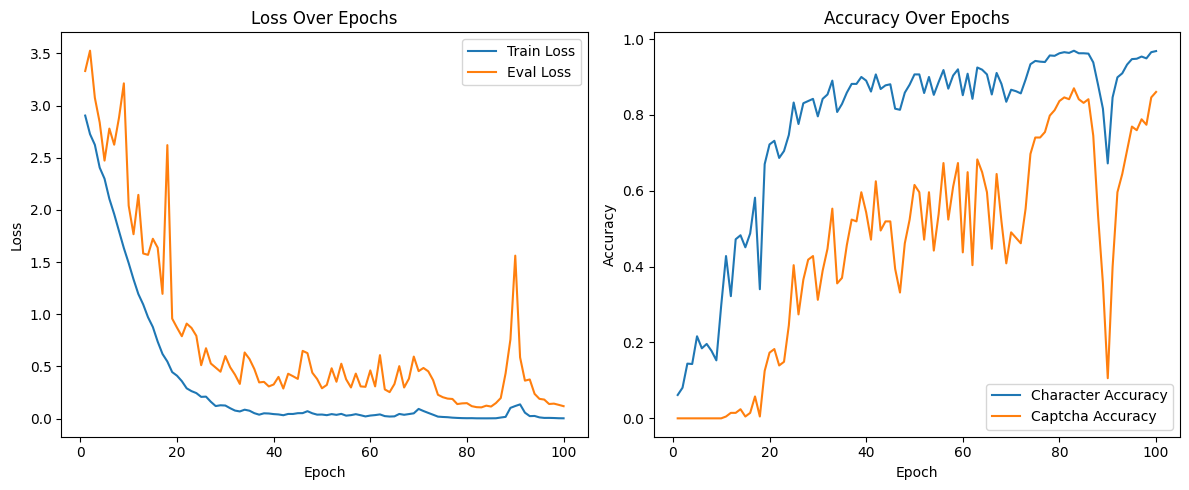

In [32]:
train_losses = [t.item() if torch.is_tensor(t) else t for t in train_losses]
eval_losses = [t.item() if torch.is_tensor(t) else t for t in eval_losses]
char_accuracies = [t.item() if torch.is_tensor(t) else t for t in char_accuracies]
captcha_accuracies = [t.item() if torch.is_tensor(t) else t for t in captcha_accuracies]

epochs_range = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, eval_losses, label='Eval Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, char_accuracies, label='Character Accuracy')
plt.plot(epochs_range, captcha_accuracies, label='Captcha Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()